In [1]:
import pandas as pd
import json
import numpy as np
import seaborn as sn
from matplotlib import pyplot as plt
from io import StringIO
%matplotlib inline

In [89]:
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import auc, roc_auc_score, roc_curve, classification_report, r2_score, mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction import DictVectorizer

In [3]:
###Data Cleanup and EDA####

In [4]:
df_movies =  pd.read_csv('5kMovies.csv')
df_credits = pd.read_csv('5kCredits.csv')

In [5]:
df_tmdb = pd.concat([df_movies, df_credits], axis=1)

In [6]:
new_column_order = ['id', 'title', 'original_language','genres', 'release_date','runtime', 'popularity', 'vote_count', 'vote_average', 'budget', 'revenue']

In [7]:
genres_list = ['Action', 'Adventure', 'Fantasy', 'Science Fiction', 'Thriller', 'Comedy']

In [8]:
def data_cleanup(df, new_columns):
    df_tmdb_new = df[new_column_order]
    df_tmdb_new = df_tmdb_new.loc[:, ~df_tmdb_new.columns.duplicated()]
    
    categorical= list(df_tmdb_new.dtypes[df_tmdb_new.dtypes=='object'].index)
    numerical = list(df_tmdb_new.dtypes[df_tmdb_new.dtypes!='object'].index)
    
    for c in categorical:
        df_tmdb_new = df = df_tmdb_new[df_tmdb_new[c].notna()]
        #df_tmdb_new.loc[:,c] = df_tmdb_new.loc[:,c].fillna('NA')

    for c in numerical:
        df_tmdb_new.loc[:,c] = df_tmdb_new.loc[:,c].fillna(0)
    
    df_filtered = df_tmdb_new[df_tmdb_new['genres'].str.len() > 2]

    df_filtered = df_filtered[df_filtered['release_date'].str.len() > 2]
    df_filtered['release_date_dt'] = pd.to_datetime(df_filtered['release_date'])
    df_filtered['release_year'] = df_filtered['release_date_dt'].dt.year
    df_filtered = df_filtered.drop('release_date', axis=1)
    df_filtered = df_filtered.drop('release_date_dt', axis=1)

    df_filtered.columns = ['id', 'title', 'language','genres','runtime', 'popularity', 'vote_count', 'vote_avg', 'budget', 'revenue', 'release_year']
    
    return df_filtered

In [9]:
def jsontocsv(jsonstr:list):
    df = pd.read_json(StringIO(jsonstr))
    csv_string = ', '.join(df['name'].apply(str))
    return csv_string

In [10]:
def genres_json_to_csv(row):
    return jsontocsv(row['genres'])

In [11]:
def normalize_genres(df_movies):
    df_movies['genres_csv'] = df_movies.apply(genres_json_to_csv, axis=1)
    for g in genres_list:
        df_movies[g] = df_movies['genres_csv'].apply(lambda x: g in x)
    df_movies = df_movies.drop('genres_csv', axis=1)
    df_movies = df_movies.drop('genres', axis=1)
    return df_movies

In [12]:
df_movies = data_cleanup(df_tmdb, new_column_order)
df_movies = normalize_genres(df_movies)

In [15]:
df_movies.columns = df_movies.columns.str.lower()
df_movies.columns = df_movies.columns.str.replace(' ','_')
df_movies.head(3)

,id,title,language,runtime,popularity,vote_count,vote_avg,budget,revenue,release_year,action,adventure,fantasy,science_fiction,thriller,comedy
0,19995,Avatar,en,162.0,150.437577,11800,7.2,237000000,2787965087,2009,True,True,True,True,False,False
1,285,Pirates of the Caribbean: At World's End,en,169.0,139.082615,4500,6.9,300000000,961000000,2007,True,True,True,False,False,False
2,206647,Spectre,en,148.0,107.376788,4466,6.3,245000000,880674609,2015,True,True,False,False,False,False


In [16]:
##### Linear Regression #####

In [41]:
features = ['id', 'title', 'runtime', 'popularity', 'vote_avg', 'budget']
df_movies = df_movies[(df_movies['budget'] > 0) & (df_movies['revenue'] > 0)].dropna(subset=features)

df_movies['log_budget'] = np.log1p(df_movies['budget'])
df_movies['log_revenue'] = np.log1p(df_movies['revenue'])

interested_features = ['runtime', 'popularity', 'vote_avg','log_budget']
target = 'log_revenue'

In [42]:
df_movies.head(3)

,id,title,language,runtime,popularity,vote_count,vote_avg,budget,revenue,release_year,action,adventure,fantasy,science_fiction,thriller,comedy,log_budget,log_revenue
0,19995,Avatar,en,162.0,150.437577,11800,7.2,237000000,2787965087,2009,True,True,True,True,False,False,19.283571,21.748578
1,285,Pirates of the Caribbean: At World's End,en,169.0,139.082615,4500,6.9,300000000,961000000,2007,True,True,True,False,False,False,19.519293,20.683485
2,206647,Spectre,en,148.0,107.376788,4466,6.3,245000000,880674609,2015,True,True,False,False,False,False,19.316769,20.596199


In [43]:
len(df_movies)

3228

In [44]:
X_full = df_movies[interested_features]
y_full = df_movies[target]

In [45]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_full, y_full, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)
len(X_train), len(X_val), len(X_test)

(1936, 646, 646)

In [46]:
reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

In [47]:
y_pred_val = reg.predict(X_val)

In [48]:
print("R^2 Score", r2_score(y_val, y_pred_val))
print("RMSE", mean_squared_error(y_val, y_pred_val))

R^2 Score 0.619931601253426
RMSE 1.7602471082978464


In [49]:
np.set_printoptions(suppress=True, precision=6)
coefficients = pd.DataFrame({'feature':interested_features, 'coefficient' : reg.coef_})
print(coefficients.round(6))

      feature  coefficient
0     runtime    -0.005564
1  popularity     0.010782
2    vote_avg     0.409942
3  log_budget     0.814482


In [50]:
####Logistic Regression ###

In [59]:
df_movies['is_hit'] = np.where(df_movies['revenue'] > (2 * df_movies['budget']), True, False)

In [66]:
interested_features = ['runtime', 'popularity', 'vote_avg','log_budget', 'log_revenue', 'is_hit']
target = 'is_hit'

In [67]:
df_full = df_movies[interested_features]

In [68]:
df_full_train, df_test = train_test_split(df_full,test_size=0.2,random_state=1)
df_train, df_val=train_test_split(df_full_train,test_size=0.25,random_state=1)
len(df_full), len(df_train), len(df_test), len(df_val)

(3228, 1936, 646, 646)

In [69]:
y_train = df_train.is_hit.values
y_val = df_val.is_hit.values
y_test = df_test.is_hit.values

del df_train['is_hit']
del df_val['is_hit']
del df_test['is_hit']

In [70]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

In [71]:
def returnAucScore(y_val, y_pred_val):
    score = roc_auc_score(y_val, y_pred_val)
    return score

In [72]:
interested_features_train = ['runtime', 'popularity', 'vote_avg','log_budget', 'log_revenue']
dv = DictVectorizer()

train_dict = df_train[interested_features_train].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[interested_features_train].to_dict(orient='records')
X_val = dv.transform(val_dict)

In [73]:
model.fit(X_train, y_train)
y_pred_val = model.predict_proba(X_val)[:,1]

In [75]:
hit_decision = (y_pred_val >= 0.5).astype(int)

df_pred = pd.DataFrame()
df_pred['actual']=y_val
df_pred['probability']=y_pred_val
df_pred['prediction']=hit_decision.astype(int)
df_pred['correct'] = df_pred.prediction == df_pred.actual

In [76]:
def returnAuc(y_val, y_pred_val):
    fpr, tpr, thresholds = roc_curve(y_val, y_pred_val)
    area =auc(fpr, tpr)
    return area

In [77]:
area = returnAuc(y_val,y_pred_val)
area

0.9996008916664233

In [78]:
def p_r_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)
    
    df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
    df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['f1_score'] = 2 * ((df_scores['p'] * df_scores['r']) / (df_scores['p'] + df_scores['r']))
    
    return df_scores

In [79]:
df_scores = p_r_dataframe(y_val, y_pred_val)

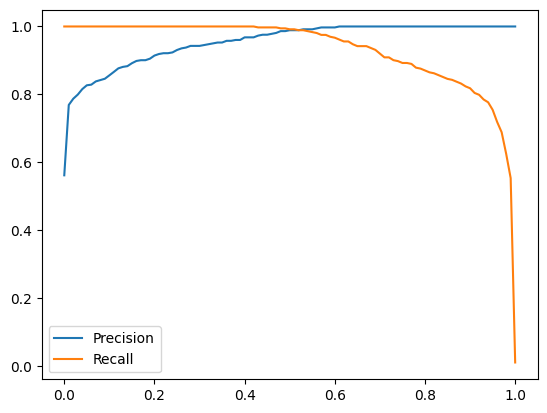

In [80]:
plt.plot(df_scores.threshold, df_scores['p'], label='Precision')
plt.plot(df_scores.threshold, df_scores['r'], label='Recall')
plt.legend()

In [81]:
max = df_scores['f1_score'].max()
max

0.9903978052126201

In [82]:
threshold = df_scores[df_scores['f1_score'] == df_scores['f1_score'].max()]['threshold']
threshold

48    0.48
49    0.49
Name: threshold, dtype: float64

In [83]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[interested_features_train].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [84]:
def predict(df, dv, model):
    dicts = df[interested_features_train].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [85]:
from tqdm.auto import tqdm
from sklearn.model_selection import KFold

In [88]:
n_splits = 5

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.is_hit.values
        y_val = df_val.is_hit.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.6f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/7 [00:00<?, ?it/s]

C=0.001 0.872 +- 0.007499
C=0.01 0.980 +- 0.003763
C=0.1 0.998 +- 0.000600
C=0.5 1.000 +- 0.000225
C=1 1.000 +- 0.000134
C=5 1.000 +- 0.000048
C=10 1.000 +- 0.000025
